In [25]:
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn.model_selection as cv
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,    
)

%matplotlib inline

In [26]:
url = "./data_balanced_normalized.csv"
df = pd.read_csv(url)

X = df.loc[:, df.columns != 'heart_attack']
y = df['heart_attack'] 

## 50/50 instead of 70/30 because of time
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size = .5, random_state=1, stratify=y) 

print(f"Total samples: {df.shape[0]}")
print(y.value_counts(normalize=True)) # to see if the heart-attack class is balanced

Total samples: 127030
heart_attack
0    0.50011
1    0.49989
Name: proportion, dtype: float64


In [27]:
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
    return wrapper

In [29]:
cv = 5

clf1 = GaussianNB()

params = {
    "n_neighbors": list(range(1,50,2)),  ##50 instead of 30 for more options
    "weights": ("distance", "uniform")
}
knc = KNeighborsClassifier()
clf = GridSearchCV(
    knc, 
    param_grid = params,
    cv = cv,
    scoring = "recall",  # we want recall and not accuracy
    n_jobs = -1
)
##clf.fit(X, y)
clf.fit(X_train, y_train)
print(f"Best Params fo Knn = {clf.best_params_}  -  Recall = {clf.best_score_}")

parval = clf.best_params_
clf2 = KNeighborsClassifier(
    n_neighbors = parval["n_neighbors"],
    weights = parval["weights"]
)

clf3 = DecisionTreeClassifier(criterion = "entropy", random_state=1)

clf4 = LinearSVC(C=5, random_state=1, max_iter=10000)
## kernel="linear", C=10
##clf4 = SVC(max_iter=1000, random_state=1)

for clf, label in zip([clf1, clf2, clf3, clf4], ["Naive Bayes",f"Knn ({clf.best_params_['n_neighbors']})", "Decision Trees" , "Linear SVM"]):
    scores = cross_val_score(
        clf, 
        X_train, ##we want to test now 
        y_train, 
        cv = cv, 
        scoring = "recall"
    )
    print("Recall: %0.3f [%s]" % (scores.mean(), label))


final_model = DecisionTreeClassifier(criterion="entropy", random_state=1)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("Recall on test set (Decision Tree):", recall_score(y_test, y_pred))

Best Params fo Knn = {'n_neighbors': 3, 'weights': 'distance'}  -  Recall = 0.6465826771653543
Recall: 0.810 [Naive Bayes]
Recall: 0.647 [Knn (3)]
Recall: 0.812 [Decision Trees]
Recall: 0.810 [Linear SVM]
Recall on test set (Decision Tree): 0.8150924380334478


In [30]:
eclf = VotingClassifier(
    estimators=[
        ("nb", clf1), 
        ("knn3", clf2), 
        ("dt", clf3),
        ("svm", clf4)
    ],
    voting = "hard")
scores = cross_val_score(
    eclf, 
    X_train, 
    y_train, 
    cv = cv, 
    scoring = "recall"
)
print("Recall: %0.3f [%s]" % (scores.mean() , "Majority Voting (hard)")) 

Recall: 0.755 [Majority Voting (hard)]


In [20]:
eclf = VotingClassifier(
    estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3), ('svm', clf4)],
    voting='hard', 
    weights=[2,1,2,2] ##found with test in the code 
)
scores = cross_val_score(eclf, X, y, cv=cv, scoring='recall')
print("Recall: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Recall: 0.818 [Weighted Voting]


In [31]:
modelGaussianNB = GaussianNB().fit(X_train, y_train)
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance').fit(X_train, y_train)
modelSVM = LinearSVC(C=5, max_iter=10000, random_state=1).fit(X_train, y_train)
##modelSVM = SVC(C=10).fit(X_train, y_train)
modelDT = DecisionTreeClassifier(criterion='entropy', random_state=1).fit(X_train, y_train)

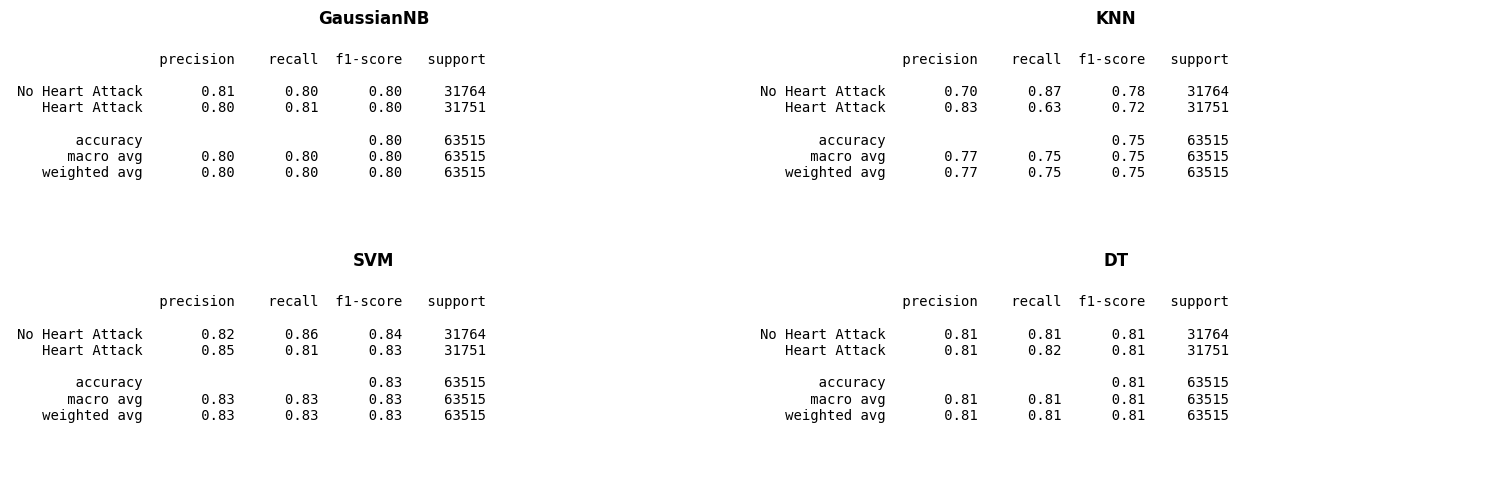

In [22]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

target_names = ['No Heart Attack', 'Heart Attack']

reportGNB = classification_report(y_test, modelGaussianNB.predict(X_test), target_names=target_names)
reportKNN = classification_report(y_test, modelKNN.predict(X_test), target_names=target_names)
reportSVM = classification_report(y_test, modelSVM.predict(X_test), target_names=target_names)
reportDT = classification_report(y_test, modelDT.predict(X_test), target_names=target_names)


reports = [reportGNB, reportKNN, reportSVM, reportDT]
titles = ['GaussianNB', 'KNN', 'SVM', 'DT']

fig, axes = plt.subplots(2, 2, figsize=(15, 5))
axes = axes.flatten()

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.90,
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    )
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


In [24]:
modelGaussianNB = GaussianNB()
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
modelDT = DecisionTreeClassifier(criterion='entropy', random_state=1)
modelSVM = LinearSVC(C=5, max_iter=10000,random_state=1) ##SVC roule pas, donc on ne peut pas faire soft voting

# Create VotingClassifier with these estimators
metaVoting = VotingClassifier(
    estimators=[
        ("GNB", modelGaussianNB),
        ("KNN", modelKNN),
        ("DT", modelDT),
        ("SVM", modelSVM)
    ],
    voting="hard"  # Soft voting requires classifiers to support predict_proba
)

# Define param grid to tune weights for each classifier
params = {
    "weights": [
        [1, 1, 1, 1],
        [2, 1, 1, 1],
        [1, 2, 1, 1],
        [1, 1, 2, 1],
        [1, 1, 1, 2],
        [2, 2, 1, 1],
        [1, 2, 2, 1],
        [1, 1, 2, 2],
        [2, 1, 1, 2],
        [2, 1, 2, 2], ## to see 
        [2, 1, 3, 2],
        [2, 2, 2, 3],
        [3, 2, 3, 3],
        [3, 1, 3, 3]
    ]
}

# Create GridSearchCV on the VotingClassifier
modelVoting = GridSearchCV(
    metaVoting,
    param_grid=params,
    cv=5,
    scoring="recall",  #we want recall
    n_jobs=-1
)

# Fit on your training data
modelVoting.fit(X_train, y_train)

print(f"Best Params for VotingClassifier = {modelVoting.best_params_} - Recall = {modelVoting.best_score_:.4f}")

Best Params for VotingClassifier = {'weights': [2, 1, 2, 2]} - Recall = 0.8165


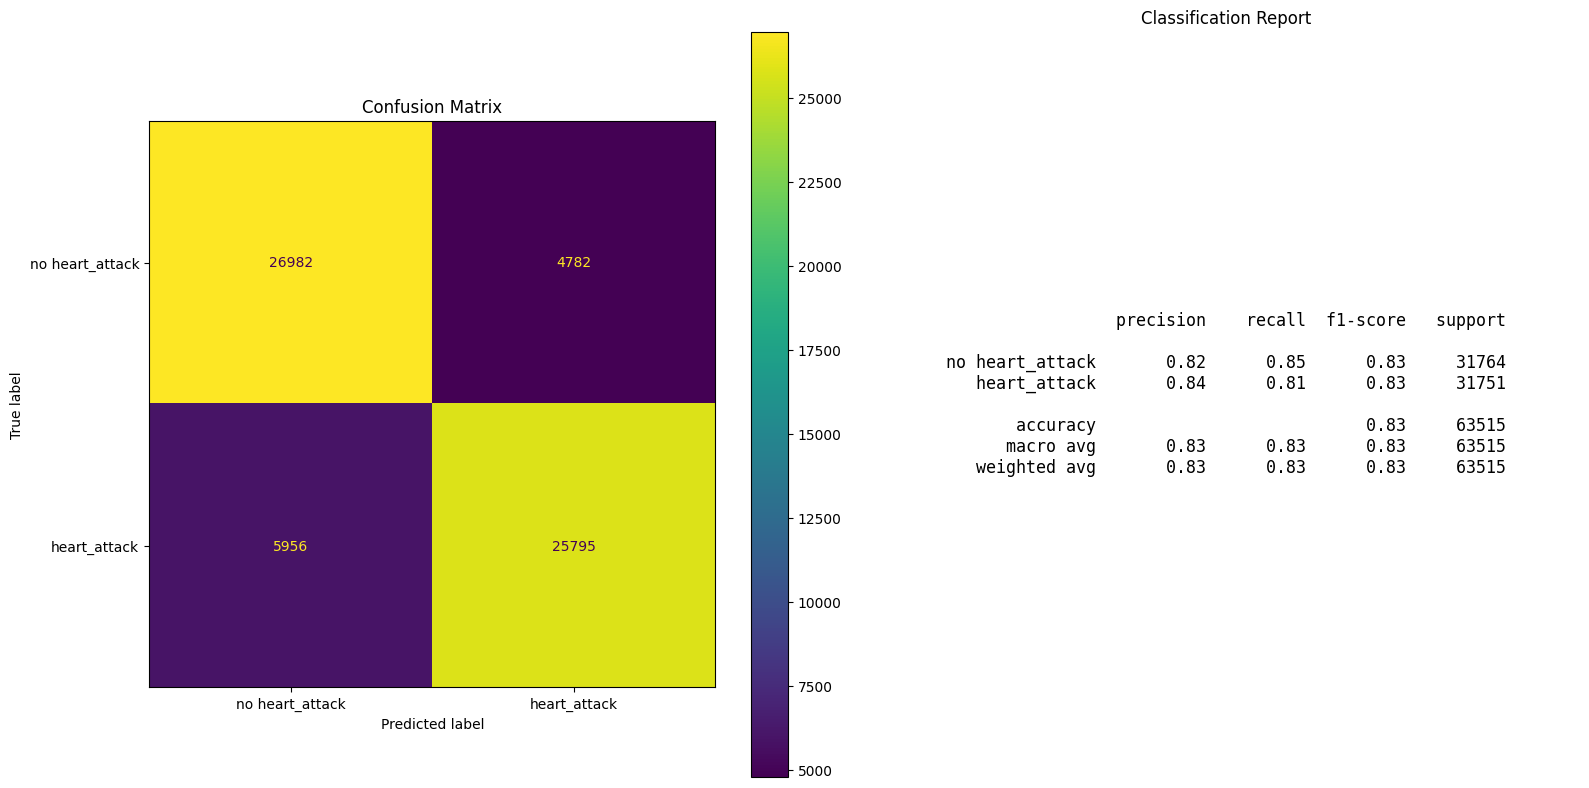

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(
    y_test, 
    modelVoting.best_estimator_.predict(X_test), 
    target_names=['no heart_attack', 'heart_attack']
)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay.from_estimator(
    modelVoting.best_estimator_, 
    X_test, 
    y_test, 
    display_labels=['no heart_attack', 'heart_attack'], 
    ax=axes[0],
)
axes[0].set_title('Confusion Matrix')
axes[1].axis('off')
axes[1].text(0.5, 0.5, report, fontsize=12, ha='center', va='center', family='monospace')
axes[1].set_title('Classification Report')
plt.tight_layout()
plt.show()

## **Bagging**

In [39]:
lb=[]
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(), 
            n_estimators = nest,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring="recall"
    )
    print(f"Recall DT: {scores.mean():.3f} [nº estimators: {nest}]")
    lb.append(scores.mean())

Recall DT: 0.808 [nº estimators: 1]
Recall DT: 0.731 [nº estimators: 2]
Recall DT: 0.811 [nº estimators: 5]
Recall DT: 0.791 [nº estimators: 10]
Recall DT: 0.799 [nº estimators: 20]
Recall DT: 0.803 [nº estimators: 50]
Recall DT: 0.804 [nº estimators: 100]
Recall DT: 0.805 [nº estimators: 200]


In [ ]:
## Refaire ça après si je veux
lb2=[]
print()
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(),
            n_estimators = nest,
            max_features = 0.35,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring="recall"
    )
    print(f"Recall: {scores.mean():.3f} [nº estimators: {nest}]")
    lb2.append(scores.mean())


Recall: 0.597 [nº estimators: 1]
Recall: 0.319 [nº estimators: 2]
Recall: 0.627 [nº estimators: 5]
Recall: 0.692 [nº estimators: 10]
Recall: 0.743 [nº estimators: 20]
Recall: 0.780 [nº estimators: 50]
Recall: 0.788 [nº estimators: 100]
Recall: 0.790 [nº estimators: 200]


In [38]:
def baggingCV(model, name):
    for nest in [1,2,5,10,20,50,100]:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = model,
                n_estimators = nest,
                random_state=1
            ), 
            X_train, 
            y_train, 
            cv = 5, 
            scoring = "recall"
        )
        print("Recall %s: %0.3f [%s]" % (name, scores.mean(), nest))
    
baggingCV(GaussianNB(), "GNB")
print()
baggingCV(KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), "KNN")
print()    

Recall GNB: 0.811 [1]
Recall GNB: 0.811 [2]
Recall GNB: 0.810 [5]
Recall GNB: 0.809 [10]
Recall GNB: 0.810 [20]
Recall GNB: 0.810 [50]
Recall GNB: 0.810 [100]

Recall KNN: 0.605 [1]
Recall KNN: 0.600 [2]
Recall KNN: 0.622 [5]
Recall KNN: 0.623 [10]
Recall KNN: 0.627 [20]
Recall KNN: 0.628 [50]
Recall KNN: 0.628 [100]



In [40]:
for nest in [1, 2, 5, 10, 20, 50, 100]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator=LinearSVC(C=5, max_iter=10000, random_state=1),
            n_estimators=nest,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv=5, 
        scoring="recall"
    )
    print("Recall %s: %0.3f [%s]" % ("LinearSVC", scores.mean(), nest))


Recall LinearSVC: 0.808 [1]
Recall LinearSVC: 0.803 [2]
Recall LinearSVC: 0.809 [5]
Recall LinearSVC: 0.808 [10]
Recall LinearSVC: 0.809 [20]
Recall LinearSVC: 0.810 [50]
Recall LinearSVC: 0.810 [100]


In [42]:
## n_estimators depending of the results found earlier
modelBaggingDT = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=1).fit(X_train, y_train)
modelBaggingGaussianNB = BaggingClassifier(estimator=GaussianNB(),n_estimators=20,random_state=1).fit(X_train, y_train)
modelBaggingKNN = BaggingClassifier(estimator=KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'),n_estimators=20,random_state=1).fit(X_train, y_train)
modelBaggingSVM = BaggingClassifier(estimator=LinearSVC(C=5, max_iter=10000), n_estimators=50, random_state=1).fit(X_train, y_train)

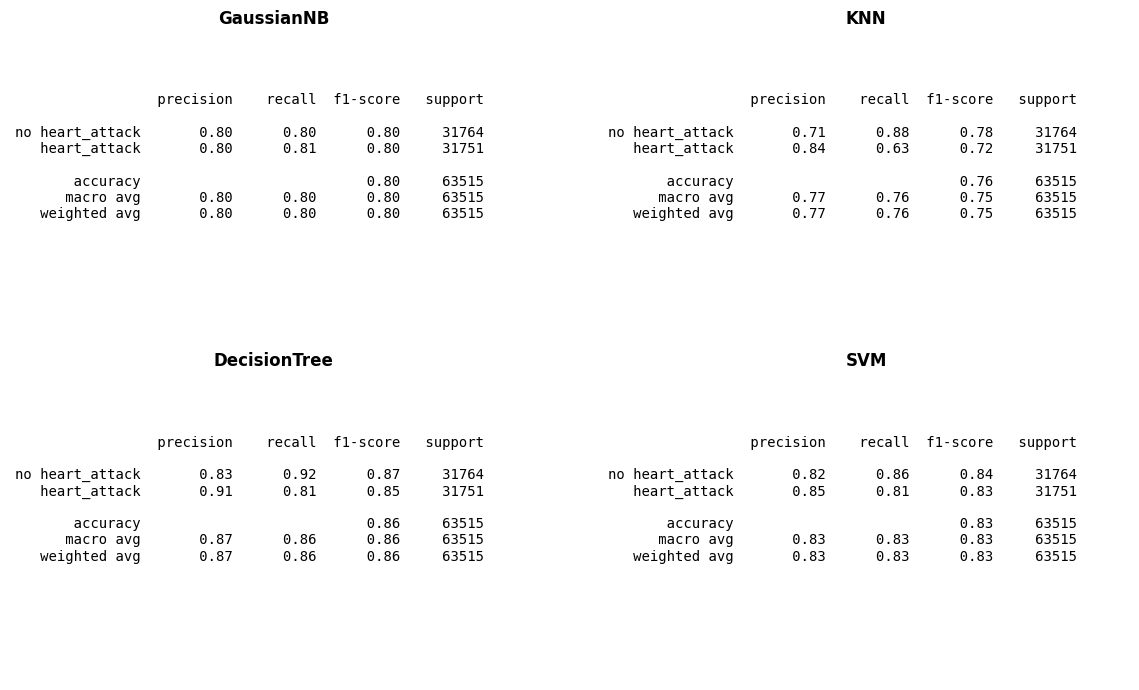

In [43]:
reportBaggingGNB = classification_report(y_test, modelBaggingGaussianNB.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportBaggingKNN = classification_report(y_test, modelBaggingKNN.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportBaggingSVM = classification_report(y_test, modelBaggingSVM.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportBaggingDT = classification_report(y_test, modelBaggingDT.predict(X_test), target_names=['no heart_attack', 'heart_attack'])


reports = [reportBaggingGNB, reportBaggingKNN, reportBaggingDT, reportBaggingSVM]
titles = ['GaussianNB', 'KNN', 'DecisionTree', 'SVM']
fig, axes = plt.subplots(2, 2, figsize=(12, 7)) 
axes = axes.flatten()  

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.80, 
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

## **Random Forest**

In [44]:
random_forest_classifier = RandomForestClassifier(
    n_estimators = 100
)

random_forest_classifier.fit(X_train, y_train)
print(f"Random Forest Score (Train): {random_forest_classifier.score(X_train, y_train)}")
print(f"Random Forest Score (Test):  {random_forest_classifier.score(X_test, y_test)}")

Random Forest Score (Train): 1.0
Random Forest Score (Test):  0.8637644650869873


In [45]:
random_forest_classifier = RandomForestClassifier(
    n_estimators = 200
)

random_forest_classifier.fit(X_train, y_train)
print(f"Random Forest Score (Train): {random_forest_classifier.score(X_train, y_train)}")
print(f"Random Forest Score (Test):  {random_forest_classifier.score(X_test, y_test)}")

Random Forest Score (Train): 1.0
Random Forest Score (Test):  0.8648193340155869


In [46]:
@compute_executions_time
def execute_random_forest_with_different_estimators_and_cv(cv=5):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200]:
        random_forest_classifier = RandomForestClassifier(
            n_estimators = n_trees,
            random_state = 1
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=cv,
            scoring="recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")
        
execute_random_forest_with_different_estimators_and_cv();

Recall: 0.775 [nº estimators (trees): 1]
Recall: 0.650 [nº estimators (trees): 2]
Recall: 0.810 [nº estimators (trees): 5]
Recall: 0.789 [nº estimators (trees): 10]
Recall: 0.802 [nº estimators (trees): 20]
Recall: 0.808 [nº estimators (trees): 50]
Recall: 0.811 [nº estimators (trees): 100]
Recall: 0.813 [nº estimators (trees): 200]

123.9835364818573 seconds


In [47]:
@compute_executions_time
def run_extra_trees_cv_experiment(cv=5):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200]:
        random_forest_classifier = ExtraTreesClassifier(
            n_estimators = n_trees,
            random_state = 1
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=cv,
            scoring="recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")
        
run_extra_trees_cv_experiment();

Recall: 0.754 [nº estimators (trees): 1]
Recall: 0.617 [nº estimators (trees): 2]
Recall: 0.786 [nº estimators (trees): 5]
Recall: 0.759 [nº estimators (trees): 10]
Recall: 0.776 [nº estimators (trees): 20]
Recall: 0.783 [nº estimators (trees): 50]
Recall: 0.787 [nº estimators (trees): 100]
Recall: 0.789 [nº estimators (trees): 200]

123.36028957366943 seconds


In [61]:
## n_estimators = 200 - see in report
modelRandomForest = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
modelExtraTrees = ExtraTreesClassifier(n_estimators=200).fit(X_train, y_train)

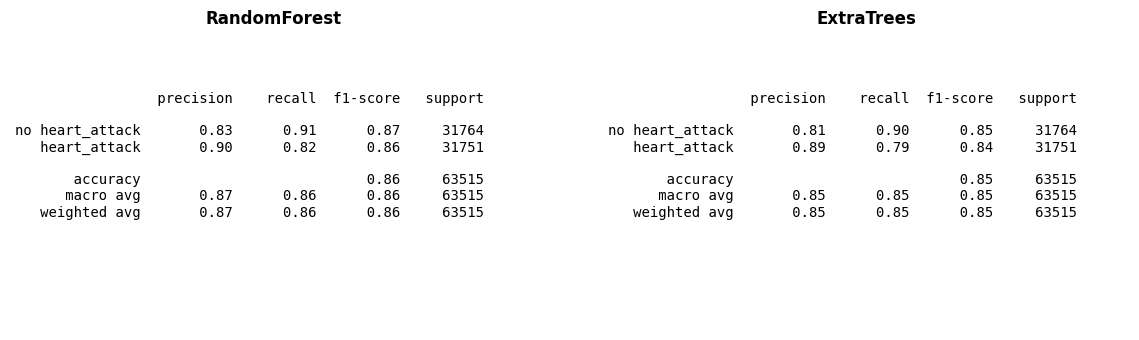

In [62]:
reportRandomForest = classification_report(y_test, modelRandomForest.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportExtraTrees = classification_report(y_test, modelExtraTrees.predict(X_test), target_names=['no heart_attack', 'heart_attack'])

reports = [reportRandomForest, reportExtraTrees]
titles = ['RandomForest', 'ExtraTrees']
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5)) 

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.80,  
        report,
        fontsize=10,
        family='monospace',
        horizontalalignment='left',
        verticalalignment='top'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [50]:
from statsmodels.stats.contingency_tables import mcnemar

predsA = modelRandomForest.predict(X_test)
predsB = modelExtraTrees.predict(X_test)
both_right = (y_test == predsA) & (y_test == predsB)
only_B_right = (y_test != predsA) & (y_test == predsB)
only_A_right = (y_test == predsA) & (y_test != predsB)
both_wrong = (y_test != predsA) & (y_test != predsB)

contingency_table = [
    [sum(both_right), sum(only_B_right)],
    [sum(only_A_right), sum(both_wrong)]
]
print(f"Contingency table: \n{contingency_table[0]}\n{contingency_table[1]}")

results_mcnemar = mcnemar(contingency_table, exact=False, correction=True)
print(f"Statistics value: {results_mcnemar.statistic}\np-value: {results_mcnemar.pvalue}")

if results_mcnemar.pvalue < 0.05:
  print("Reject Null hypothesis")
else:
  print("Fail to reject Null hypothesis, we can not distinguish both models")

Contingency table: 
[52019, 1611]
[2944, 6941]
Statistics value: 389.5113062568606
p-value: 1.0574665745610124e-86
Reject Null hypothesis


In [51]:
from statsmodels.stats.contingency_tables import mcnemar

# Get predictions from both models
pred_rf = modelRandomForest.predict(X_test)
pred_et = modelExtraTrees.predict(X_test)

both_correct = (y_test == pred_rf) & (y_test == pred_et)
only_et_correct = (y_test != pred_rf) & (y_test == pred_et)
only_rf_correct = (y_test == pred_rf) & (y_test != pred_et)
both_wrong = (y_test != pred_rf) & (y_test != pred_et)

table_data = {
    'ExtraTrees Correct': [both_correct.sum(), only_rf_correct.sum()],
    'ExtraTrees Wrong': [only_et_correct.sum(), both_wrong.sum()]
}
index_labels = ['RandomForest Correct', 'RandomForest Wrong']
contingency_df = pd.DataFrame(table_data, index=index_labels)

print("\n Contingency Table:\n")
print(contingency_df)

results_mcnemar = mcnemar(contingency_df.values, exact=False, correction=True)

print("\n McNemar Test Results:")
print(f"Statistics value: {results_mcnemar.statistic}")
print(f"p-value: {results_mcnemar.pvalue}")


if results_mcnemar.pvalue < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis: No significant difference between the models.")



 Contingency Table:

                      ExtraTrees Correct  ExtraTrees Wrong
RandomForest Correct               52019              1611
RandomForest Wrong                  2944              6941

 McNemar Test Results:
Statistics value: 389.5113062568606
p-value: 1.0574665745610124e-86
Reject the null hypothesis


In [ ]:
## comparaison -- a faire??? a  voir si je veux

plt.figure(figsize = (20, 10))
plt.title("Evolution of acc of different methods for different number of estimators (detail)")
plt.plot([1,2,5,10,20,50,100,200],lb,label = "Bagging DT")
##plt.plot([1,2,5,10,20,50,100,200],lb2,label = "Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label = "Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label = "Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label = "Gradient Boosting")
plt.legend(loc = "lower right")
plt.xlim(10,200)
plt.ylim(0.90,0.96)
plt.show()

## **Ada Boost Classifier**

In [52]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=5):
    for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=1
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X_train,
            y_train,
            cv = cv,
            scoring = "recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators: {n_estimators}]")

execute_ada_boost_classifier_for_different_classifiers()

Recall: 0.423 [nº estimators: 1]
Recall: 0.423 [nº estimators: 2]
Recall: 0.715 [nº estimators: 5]
Recall: 0.765 [nº estimators: 10]
Recall: 0.798 [nº estimators: 20]
Recall: 0.821 [nº estimators: 50]
Recall: 0.852 [nº estimators: 100]
Recall: 0.852 [nº estimators: 200]

67.56616973876953 seconds


In [ ]:
## with cv = 10 to do compare  
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=10):
    for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=1
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X,
            y,
            cv = cv,
            scoring = "recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators: {n_estimators}]")

execute_ada_boost_classifier_for_different_classifiers()

Recall: 0.450 [nº estimators: 1]
Recall: 0.450 [nº estimators: 2]
Recall: 0.783 [nº estimators: 5]
Recall: 0.664 [nº estimators: 10]
Recall: 0.791 [nº estimators: 20]
Recall: 0.813 [nº estimators: 50]
Recall: 0.851 [nº estimators: 100]
Recall: 0.853 [nº estimators: 200]

412.30670714378357 seconds


In [54]:
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(LinearSVC(C=5, max_iter=10000), n_estimators = n_estimators, random_state=1), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring = "recall"
    )
    print("Recall adaBoost LinearSVC: %0.3f [%s]" % (scores.mean(), n_estimators))

Recall adaBoost LinearSVC: 0.793 [1]
Recall adaBoost LinearSVC: 0.793 [2]
Recall adaBoost LinearSVC: 0.793 [5]
Recall adaBoost LinearSVC: 0.793 [10]
Recall adaBoost LinearSVC: 0.793 [20]
Recall adaBoost LinearSVC: 0.793 [50]
Recall adaBoost LinearSVC: 0.793 [100]
Recall adaBoost LinearSVC: 0.793 [200]


In [55]:
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(GaussianNB(), n_estimators = n_estimators, random_state=1), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring = "recall"
    )
    print("Recall: %0.3f [%s]" % (scores.mean(), n_estimators))
print()
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators = n_estimators, random_state=1), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring = "recall"
    )
    print("Recall: %0.3f [%s]" % (scores.mean(), n_estimators))

Recall: 0.810 [1]
Recall: 0.810 [2]
Recall: 0.848 [5]
Recall: 0.854 [10]
Recall: 0.854 [20]
Recall: 0.854 [50]
Recall: 0.854 [100]
Recall: 0.854 [200]

Recall: 0.765 [1]
Recall: 0.765 [2]
Recall: 0.813 [5]
Recall: 0.818 [10]
Recall: 0.825 [20]
Recall: 0.825 [50]
Recall: 0.826 [100]
Recall: 0.823 [200]


In [56]:
modelAdaboostGNB = AdaBoostClassifier(GaussianNB(), n_estimators=100, random_state=1).fit(X_train, y_train)
modelAdaboostDT = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=1).fit(X_train, y_train)
modelAdaboostSVC = AdaBoostClassifier(LinearSVC(C=5, max_iter=10000), n_estimators = 100, random_state=1).fit(X_train, y_train)

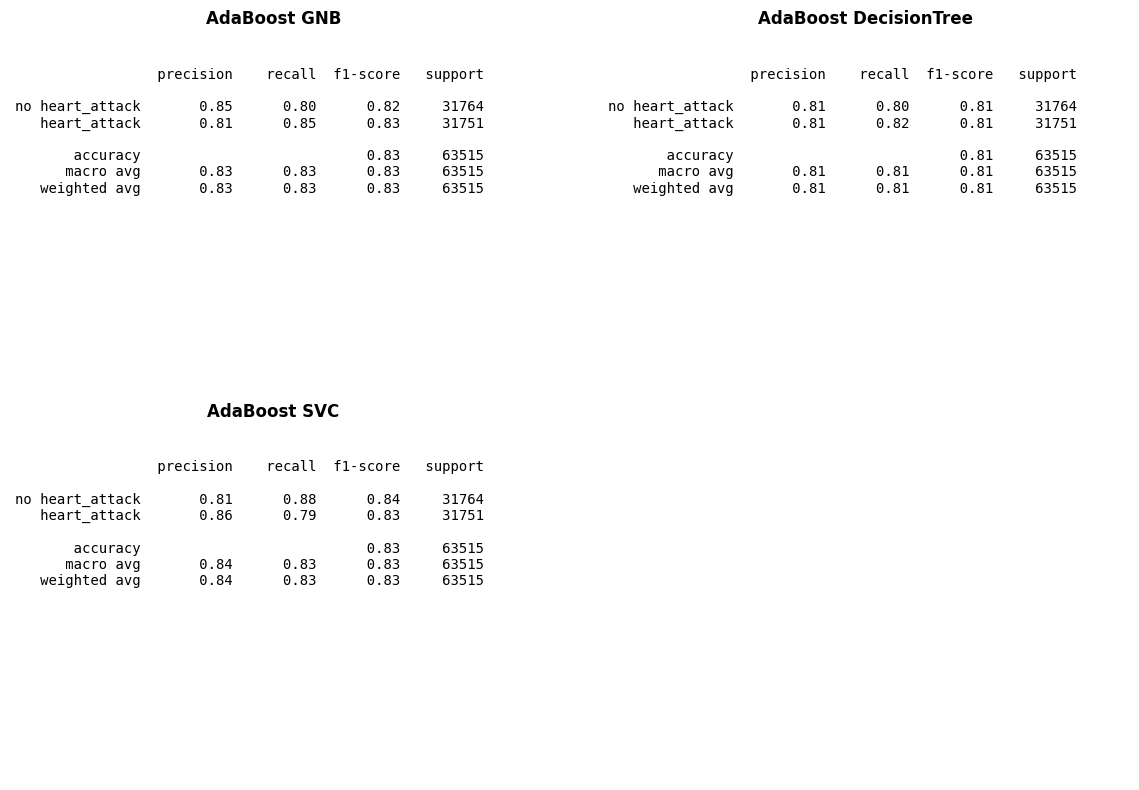

In [59]:
reportAdaboostGNB = classification_report(y_test, modelAdaboostGNB.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportAdaboostDT = classification_report(y_test, modelAdaboostDT.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportAdaboostSVC = classification_report(y_test, modelAdaboostSVC.predict(X_test), target_names=['no heart_attack', 'heart_attack'])


reports = [reportAdaboostGNB, reportAdaboostDT, reportAdaboostSVC]
titles = ['AdaBoost GNB', 'AdaBoost DecisionTree', 'AdaBoost SVC']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.90, 
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

    if len(reports) < len(axes):
        for j in range(len(reports), len(axes)):
            axes[j].axis('off')

plt.tight_layout()
plt.show()